In [1]:
import os, sys, re, csv
import heapq
import json
import string
import gensim
from gensim import corpora, models, similarities
import itertools
import json
from operator import itemgetter
import nltk
from nltk import *
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

If you have no idea how many topics the corpus should yield - compute them by reducing the features to two dimensions, then clustering the points for different values of K (number of clusters) to find an optimum value. Gensim offers various transforms that allow us to project the vectors in a corpus to a different coordinate space. One such transform is the Latent Semantic Indexing (LSI) transform, which we use to project the original data to 2D.

In [2]:
MODELS_DIR = "/Users/dariaulybina/Desktop/georgetown-analytics_global-economics/global-economics/KeywordsANDClustering/models/"

dictionary = gensim.corpora.Dictionary.load(os.path.join(MODELS_DIR, 
                                            "GenDict.dict"))
corpus = gensim.corpora.MmCorpus(os.path.join(MODELS_DIR, "CorpSer.mm"))

tfidf = gensim.models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# project to 2 dimensions for visualization
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

# write out coordinates to file
fcoords = open(os.path.join(MODELS_DIR, "coords.csv"), 'w')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

__Reduction of 2D LSI space__

Clustered points in the reduced 2D LSI space using KMeans, varying the number of clusters (K) from 1 to 10. The objective function used is the Inertia of the cluster, defined as the sum of squared differences of each point to its cluster centroid. This value is provided directly from the Scikit-Learn KMeans algorithm. Other popular functions include Distortion (Inertia divided by the number of points) or the Percentage of Variance Explained.

__K-means: elbow curve__

Below are plotted Inertias for different values of K, combined with Vincent Granville's approach of calculating the third differential to find an elbow point. The elbow point here is K=5 and is marked with a red dot in the graph below.

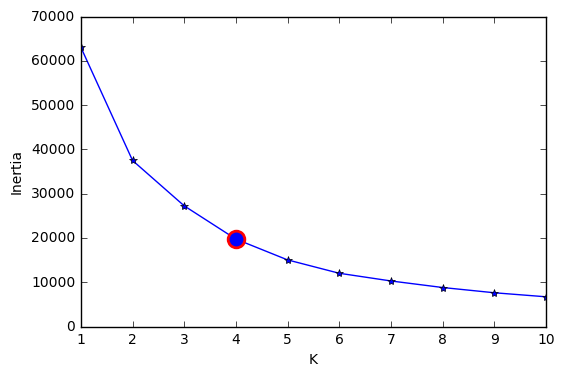

In [3]:
MAX_K = 10

X = np.loadtxt(os.path.join(MODELS_DIR, "coords.csv"), delimiter="\t")
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

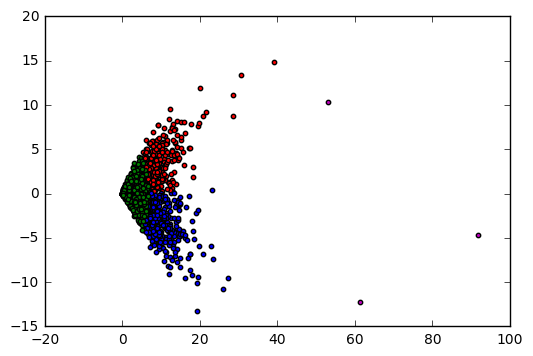

In [4]:
NUM_TOPICS = 4 #compare with 4 and 5

X = np.loadtxt(os.path.join(MODELS_DIR, "coords.csv"), delimiter="\t")
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m"]#,"c"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

Then, run the full LDA transform against the BoW corpus, with the number of topics set to 5. As in LSI, load up the corpus and dictionary from files, then apply the transform to project the documents into the LDA Topic space. Notice that LDA and LSI are conceptually similar in gensim - both are transforms that map one vector space to another.

In [5]:
NUM_TOPICS = 4

dictionary = gensim.corpora.Dictionary.load(os.path.join(MODELS_DIR, 
                                            "GenDict.dict"))
corpus = gensim.corpora.MmCorpus(os.path.join(MODELS_DIR, "CorpSer.mm"))

# Project to LDA space
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS)
lda.print_topics(NUM_TOPICS)

[(0,
  '0.020*"authorities" + 0.013*"percent" + 0.012*"percent of gdp" + 0.011*"staff" + 0.006*"page" + 0.004*"budget" + 0.004*"government" + 0.004*"medium term" + 0.004*"us" + 0.003*"box"'),
 (1,
  '0.014*"percent" + 0.012*"authorities" + 0.011*"percent of gdp" + 0.005*"growth" + 0.005*"staff" + 0.005*"page" + 0.004*"inflation" + 0.003*"government" + 0.003*"economy" + 0.003*"box"'),
 (2,
  '0.016*"percent" + 0.009*"percent of gdp" + 0.008*"authorities" + 0.004*"growth" + 0.004*"page" + 0.004*"banks" + 0.003*"figure" + 0.003*"government" + 0.003*"years" + 0.003*"inflation"'),
 (3,
  '0.012*"authorities" + 0.010*"percent of gdp" + 0.008*"percent" + 0.005*"banks" + 0.005*"page" + 0.004*"rbz" + 0.003*"staff" + 0.003*"risks" + 0.002*"box" + 0.002*"addition"')]